### Modelo básico. Decision Tree

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
from sklearn.feature_selection import SelectKBest, f_classif

In [3]:
df = pd.read_csv("../data/processed/processed_new_columns.csv", index_col=0)

In [4]:
df.head(5)

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,...,explicit,artists_frequency,version_type,base_name,version_Live,version_Original,version_Remaster,version_Remix,version_type_encoded,decade
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,...,0,51,Original,!Que Vida! - Mono Version,0,1,0,0,1,1960
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,...,0,218,Original,"""40""",0,1,0,0,1,1980
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,...,0,218,Live,"""40"" -",1,0,0,0,0,1980
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,0,218,Remaster,"""40"" - 2008",0,0,1,0,2,1980
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,0,218,Remaster,"""40"" - 2008",0,0,1,0,2,1980


Comenzamos tomando la decisión de centrarnos en las décadas desde 1950 hasta la de 2010, ambas incluidas. Esta decisión se fundamenta en dos motivos principales:

- Motivo estadístico: El análisis descriptivo previo nos ha mostrado una descompensación de datos en función de las décadas. El periodo escogido sí tiene una representación equilibrada.
- Motivo de negocio: Si el objetivo es que personas de edad avanzada puedan escuchar canciones de ahora que suenan a décadas pasadas, esas en las que ellos eran más jóvenes y descubrían nueva música, contar con décadas anteriores a los 50 no tendría mucho sentido por el propio perfil (edad) de los usuarios.

In [5]:
#Incluimos solo canciones entre las décadas de 1950 y 2010
df = df[(df['decade'] >= 1950) & (df['decade'] <= 2010)]

In [ ]:
#Agrupación
def asignar_rango_decada(decade):
    if 1950 <= decade <= 1969:
        return '50s-60s'
    elif 1970 <= decade <= 1989:
        return '70s-80s'
    elif 1990 <= decade <= 2009:
        return '90s-00s'
    else:
        return 'Otros' 

In [7]:
df['decade_range'] = df['decade'].apply(asignar_rango_decada)

In [8]:
#Nueva variable target para poder utilizar en el modelo XGBoost
decade_mapping = {}
for idx, decade in enumerate(sorted(df['decade_range'].unique())):
    decade_mapping[decade] = idx
df['decade_label'] = df['decade_range'].map(decade_mapping)

In [9]:
df.head(5)

,id,name,artists,duration_ms,release_date,year,acousticness,danceability,energy,instrumentalness,...,version_type,base_name,version_Live,version_Original,version_Remaster,version_Remix,version_type_encoded,decade,decade_range,decade_label
0,0gNNToCW3qjabgTyBSjt3H,!Que Vida! - Mono Version,['Love'],220560,11/1/66,1966,0.5250,0.600,0.540,0.00305,...,Original,!Que Vida! - Mono Version,0,1,0,0,1,1960,50s-60s,0
1,0tMgFpOrXZR6irEOLNWwJL,"""40""",['U2'],157840,2/28/83,1983,0.2280,0.368,0.480,0.70700,...,Original,"""40""",0,1,0,0,1,1980,70s-80s,1
2,2ZywW3VyVx6rrlrX75n3JB,"""40"" - Live",['U2'],226200,8/20/83,1983,0.0998,0.272,0.684,0.01450,...,Live,"""40"" -",1,0,0,0,0,1980,70s-80s,1
3,6DdWA7D1o5TU2kXWyCLcch,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,Remaster,"""40"" - 2008",0,0,1,0,2,1980,70s-80s,1
4,3vMmwsAiLDCfyc1jl76lQE,"""40"" - Remastered 2008",['U2'],157667,2/28/83,1983,0.1850,0.371,0.545,0.58200,...,Remaster,"""40"" - 2008",0,0,1,0,2,1980,70s-80s,1


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 139848 entries, 0 to 169906
Data columns (total 30 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    139848 non-null  object 
 1   name                  139848 non-null  object 
 2   artists               139848 non-null  object 
 3   duration_ms           139848 non-null  int64  
 4   release_date          139848 non-null  object 
 5   year                  139848 non-null  int64  
 6   acousticness          139848 non-null  float64
 7   danceability          139848 non-null  float64
 8   energy                139848 non-null  float64
 9   instrumentalness      139848 non-null  float64
 10  liveness              139848 non-null  float64
 11  loudness              139848 non-null  float64
 12  speechiness           139848 non-null  float64
 13  tempo                 139848 non-null  float64
 14  valence               139848 non-null  float64
 15  mode 

In [11]:
df.columns

Index(['id', 'name', 'artists', 'duration_ms', 'release_date', 'year',
       'acousticness', 'danceability', 'energy', 'instrumentalness',
       'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
       'key', 'popularity', 'explicit', 'artists_frequency', 'version_type',
       'base_name', 'version_Live', 'version_Original', 'version_Remaster',
       'version_Remix', 'version_type_encoded', 'decade', 'decade_range',
       'decade_label'],
      dtype='object')

In [12]:
X = df[['duration_ms', 'acousticness', 'danceability', 'energy', 'instrumentalness',
      'liveness', 'loudness', 'speechiness', 'tempo', 'valence', 'mode',
      'key', 'popularity', 'explicit', 'version_type_encoded']]
y = df['decade_label']

In [13]:
#Dividimos en conjuntos para entrenamiento y pruebas
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.2, random_state=42)

In [14]:
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(139848, 15)
(27969, 15)
(111879, 15)
(27969,)
(111879,)


In [15]:
model_1 = XGBClassifier(n_estimators=100, random_state=42)

In [16]:
#Entrenamiento
model_1.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [17]:
#Evaluación
y_pred_1 = model_1.predict(X_test)
accuracy_1 = accuracy_score(y_test, y_pred_1)
precision_1 = precision_score(y_test, y_pred_1, average='macro')
recall_1 = recall_score(y_test, y_pred_1, average='macro')
f1_1 = f1_score(y_test, y_pred_1, average='macro')

In [18]:
print("Accuracy del modelo RandomForestClassifier:", accuracy_1)
print("Precisión (Precision):", precision_1)
print("Sensibilidad (Recall):", recall_1)
print("F1-Score:", f1_1)

Accuracy del modelo RandomForestClassifier: 0.7125018993734302
Precisión (Precision): 0.7165008100890954
Sensibilidad (Recall): 0.7068010441295146
F1-Score: 0.71099110771488


<mark>**Observación:**</mark> Mejora significativa: El modelo de Random Forest está funcionando mejor que el Decision Tree en todos los aspectos evaluados. Esto es consistente con la capacidad del Random Forest de capturar patrones complejos y reducir el sobreajuste en comparación con un solo árbol de decisión. No obstante, hay mucho margen de mejora.

In [19]:
print("Reporte de clasificación:")
print(classification_report(y_test, y_pred_1))

Reporte de clasificación:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84     32009
           1       0.67      0.68      0.67     31973
           2       0.62      0.67      0.65     31985
           3       0.71      0.67      0.69     15912

    accuracy                           0.71    111879
   macro avg       0.72      0.71      0.71    111879
weighted avg       0.72      0.71      0.71    111879



In [20]:
#Matriz de confusión
print("Matriz de confusión:")
conf_matrix_1 = confusion_matrix(y_test, y_pred_1)
print(conf_matrix_1)

Matriz de confusión:
[[25919  4417  1512   161]
 [ 3158 21648  6621   546]
 [  771  6025 21529  3660]
 [   56   260  4978 10618]]


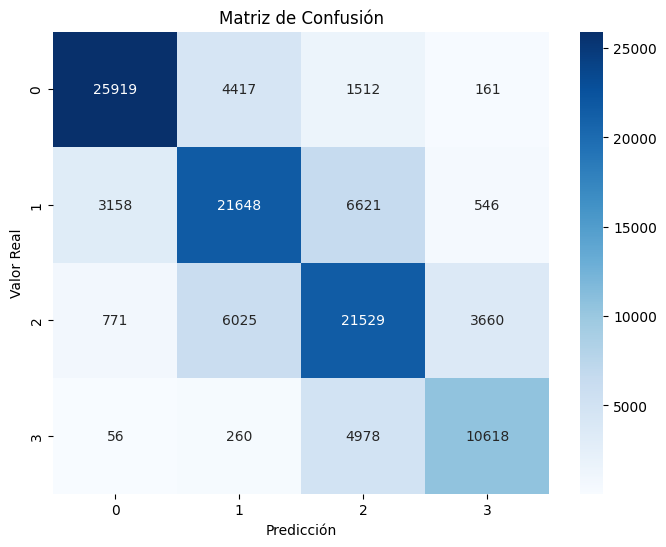

In [21]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix_1, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

<mark>**Observaciones:**</mark>

- **Clase dominante (esquinas):** En las décadas más recientes y antiguas, como en las esquinas de la matriz (la primera y última filas y columnas), se puede ver que el modelo tiene un número notable de clasificaciones correctas, pero también muestra errores considerables.
- **Confusión entre décadas cercanas.** El modelo tiende a confundir décadas consecutivas. Por ejemplo, en las filas centrales (correspondientes a décadas como los 70s, 80s y 90s), hay un número significativo de errores entre décadas vecinas. Esto puede indicar que las características en el estilo y producción musical de las canciones de esas décadas son similares, haciendo difícil la distinción.
- **Desempeño general aceptable:** Aunque hay errores, el modelo básico está funcionando razonablemente bien, clasificando correctamente una gran cantidad de canciones en sus respectivas décadas.

In [22]:
#ROC-AUC multiclase (aunque es una métrica más favorable para modelos de clasificación binaria)
y_test_binarized_1 = label_binarize(y_test, classes=np.unique(y))
y_pred_proba_1 = model_1.predict_proba(X_test)
auc_score_1 = roc_auc_score(y_test_binarized_1, y_pred_proba_1, average='macro')
print("ROC-AUC Score (macro-average):", auc_score_1)

ROC-AUC Score (macro-average): 0.9179484268878699


En un caso multiclase como este, se evalúa la capacidad del modelo para predecir correctamente cada clase en comparación con las demás.

### Optimización 1: Feature importance

In [23]:
feature_importances = model_1.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [24]:
importance_df

,Feature,Importance
12,popularity,0.446260
13,explicit,0.139473
1,acousticness,0.053752
6,loudness,0.052980
14,version_type_encoded,0.041272
0,duration_ms,0.039650
9,valence,0.032886
3,energy,0.030249
4,instrumentalness,0.028961
2,danceability,0.027724


In [25]:
X_reduc = df[['duration_ms', 'acousticness', 'danceability', 'energy', 
              'loudness', 'speechiness', 'valence', 'popularity', 
              'instrumentalness', 'explicit', 'version_type_encoded']]

In [26]:
#Dividimos en conjuntos para entrenamiento y pruebas
X_train_reduc, X_test_reduc, y_train, y_test = train_test_split(X_reduc, y, train_size=0.2, random_state=42)

In [27]:
print(X.shape)
print(X_train_reduc.shape)
print(X_test_reduc.shape)
print(y_train.shape)
print(y_test.shape)

(139848, 15)
(27969, 11)
(111879, 11)
(27969,)
(111879,)


In [28]:
model_2 = XGBClassifier(n_estimators=100, random_state=42)

In [29]:
#Entrenamiento
model_2.fit(X_train_reduc, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [30]:
#Evaluación
y_pred_2 = model_2.predict(X_test_reduc)
accuracy_2 = accuracy_score(y_test, y_pred_2)
precision_2 = precision_score(y_test, y_pred_2, average='macro')
recall_2 = recall_score(y_test, y_pred_2, average='macro')
f1_2 = f1_score(y_test, y_pred_2, average='macro')

In [31]:
print("Accuracy del modelo RandomForest:", accuracy_2)
print("Precisión (Precision):", precision_2)
print("Sensibilidad (Recall):", recall_2)
print("F1-Score:", f1_2)

Accuracy del modelo RandomForest: 0.7049937879316047
Precisión (Precision): 0.7098161628993599
Sensibilidad (Recall): 0.6992489754811888
F1-Score: 0.7037403979174925


<mark>**Conclusiones:**</mark> 

- Haciendo una selección de variables (feature importance > 5) el modelo empeora mínimamente, lo que confirma que estas características tienen una importancia mínima en la predicción de la década.

- La ligera caída en las métricas sugiere que las características eliminadas (key, explicit, mode, version_type_encoded) eran redundantes o no contribuían significativamente a la predicción.

- La reducción en la complejidad del modelo puede ser beneficiosa en términos de eficiencia y generalización, aunque no se logró una mejora en el rendimiento.



### Optimización 2: SelectKBest

In [32]:
k = 10
selector = SelectKBest(score_func=f_classif, k=k)
X_new = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]

In [33]:
print(f"Características seleccionadas con SelectKBest (top {k}):")
print(selected_features)

Características seleccionadas con SelectKBest (top 10):
Index(['duration_ms', 'acousticness', 'danceability', 'energy',
       'instrumentalness', 'loudness', 'speechiness', 'valence', 'popularity',
       'explicit'],
      dtype='object')


In [34]:
X_train_k, X_test_k, y_train, y_test = train_test_split(X_new, y, train_size=0.2, random_state=42)

In [35]:
print(X.shape)
print(X_train_k.shape)
print(X_test_k.shape)
print(y_train.shape)
print(y_test.shape)

(139848, 15)
(27969, 10)
(111879, 10)
(27969,)
(111879,)


In [36]:
model_3 = XGBClassifier(n_estimators=100, random_state=42)

In [37]:
#Entrenamiento
model_3.fit(X_train_k, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [38]:
#Evaluación
y_pred_3 = model_3.predict(X_test_k)
accuracy_3 = accuracy_score(y_test, y_pred_3)
precision_3 = precision_score(y_test, y_pred_3, average='macro')
recall_3 = recall_score(y_test, y_pred_3, average='macro')
f1_3 = f1_score(y_test, y_pred_3, average='macro')

In [40]:
print("Accuracy del modelo XGBoost:", accuracy_3)
print("Precisión (Precision):", precision_3)
print("Sensibilidad (Recall):", recall_3)
print("F1-Score:", f1_3)

Accuracy del modelo XGBoost: 0.7024285165223143
Precisión (Precision): 0.7068967378504654
Sensibilidad (Recall): 0.6969105124547574
F1-Score: 0.7011758399923249


<mark>**Conclusión:**</mark> SelectKBest no mejoró significativamente el modelo. Esto sugiere que el modelo ya estaba utilizando las características más relevantes de manera efectiva.



### Optimización 3: Hiperparametrización

In [ ]:
#Configuración de hiperparámetros para RandomForest
param_grid = {
    'n_estimators': [100, 200, 300],  # Aumentar el número de estimadores
    'max_depth': [3, 5, 7, 10],            # Explorar más profundidades
    'learning_rate': [0.01, 0.05, 0.1, 0.2],  # Variar la tasa de aprendizaje
    'subsample': [0.6, 0.7, 0.8, 1.0],      # Ampliar el rango de subsample
    'colsample_bytree': [0.6, 0.8, 1.0]     # Variar la proporción de columnas seleccionadas
}

In [50]:
grid_search = GridSearchCV(XGBClassifier(n_estimators=100, random_state=42), param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_train_k, y_train)

Fitting 5 folds for each of 768 candidates, totalling 3840 fits
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   0.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   1.9s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   8.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=  11.5s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.6; total time=   8.1s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   3.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.7s
[CV] END colsample_bytree=0.6, learning_rate=0.01, max_depth=3, n_estimators=100, subsample=0.7; total time=   2.1s
[CV] END

KeyboardInterrupt: 

In [44]:
# Mostrar los mejores parámetros encontrados
grid_best_params = grid_search.best_params_
print("Mejores hiperparámetros:", grid_best_params)

Mejores hiperparámetros: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.7}


In [45]:
#Evaluación del modelo
best_model = grid_search.best_estimator_
y_pred_4 = best_model.predict(X_test_k)
accuracy_4 = accuracy_score(y_test, y_pred_4)
precision_4 = precision_score(y_test, y_pred_4, average='macro')
recall_4 = recall_score(y_test, y_pred_4, average='macro')
f1_4 = f1_score(y_test, y_pred_4, average='macro')

In [47]:
print("Accuracy del modelo XGBoost:", accuracy_4)
print("Precisión (Precision):", precision_4)
print("Sensibilidad (Recall):", recall_4)
print("F1-Score:", f1_4)

Accuracy del modelo XGBoost: 0.7069512598432235
Precisión (Precision): 0.713153984395999
Sensibilidad (Recall): 0.7003619158210584
F1-Score: 0.705507984144818


<mark>**Conclusión:**</mark> La hiperparametrización ha mejorado el modelo de forma significativa, mostrando que ajustar la profundidad a 10, el mínimo de muestras por hoja a 2 y los nodos mínimos a 2 mejora la capacidad de generalización. No obstante, el rendimiento sigue siendo moderado y deberemos probar con otro modelos.